### Prelab
Input voltage Vg = 18 V
Output voltage V = 8 V
Output power Pout = 12 W
Switching frequency fs = 50 kHz
Duty cycle D = 35%
Assume 60 uF for the output capacitance C

L_crit = (1 - M) * R * Ts
L_crit = (1 - (V/Vg)) * V^2/Pout * 1/fs

D^2 = M^2/(1-M) * 2fs * L/R
L = D^2 * (1-M)/M^2 * R/2fs


ipk_dcm = 1/sqrt(L/L_crit) * V/R

In [138]:
import math
# Parameters
Vg = 18
V = 8
D = 0.35
Pout = 12; # W
fs = 50e3

# Calculated
M = V/Vg
R = V**2/Pout
Ts = 1/fs
L = D**2 * (1-M)/(M**2) * R / (2*fs)
L_crit = (1-M) * R * (Ts/2)
ipk_dcm = 2/math.sqrt(L/L_crit) * V / R

print("R: ", R)
print("L: ", L)
print("L_crit: ", L_crit)
print("alpha", L/L_crit)
print("ipk: ", ipk_dcm)

R:  5.333333333333333
L:  1.8375e-05
L_crit:  2.962962962962963e-05
alpha 0.62015625
ipk:  3.8095238095238093


In [139]:
D = 0.5
K = 2 * fs * L / R
M_dcm = D*(math.sqrt(D**2+4*K)-D)/(2*K)
Vout = M_dcm*Vg
print("Vout @D=0.5: ", Vout)


Vout @D=0.5:  10.135249182269186


### Task 1

Q1: Calculate the switching frequency according to the RC values and equation provided in the UC2844 datasheet.


$f_s = \frac{1}{2}f_{\text{osc}}$ 

$\; \, \; \; \, = \frac{1}{2}\times\frac{1.72}{RC}$

$\; \, \; \; \, = \frac{1}{2}\times\frac{1.72}{7870 \Omega \, \times \, 2.2 \text{nF}}$

$\; \, \; \; \, = 49670 \; \text{Hz}$

Q2: Attach a PLECS scope to pin 6 (OUTPUT) of the UC2844, run a simulation, and measure the actual switching frequency. Confirm the correctness of what you see (how good is the match?).

$ \frac{1}{t_2-t_1}$

$= \frac{1}{0.00023061781655240451 \, \text{s} - 0.0002100031107761406 \, \text{s}}$

$= 48509 \; \text{Hz}$

This is a relatively good match and matches our initial parameters. It is within 0.7% of our calculated frequency.

Q3: What percentage is the duty cycle, and why is it at that particular value?

The duty cycle is at 50% because it is the maximum duty cycle for the UC2844 per the datasheet. We left isense being tied to ground, so it will attempt to reach the maximum current each cycle because the assumed current is none.

Q4:

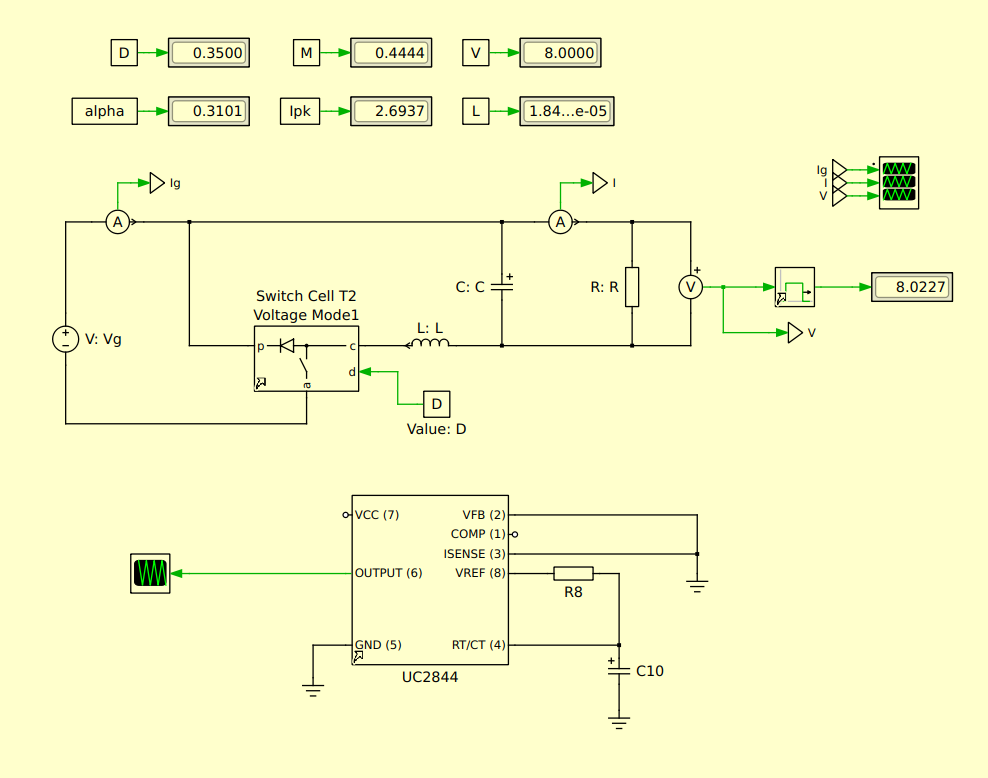

PLECS initialization:
```
R8 = 7870;
C10 = 2.2e-9;

fosc = 1.72 / (R8 * C10);
fs = 48059;
Ts = 1/fs;

C = 60e-6;

Vg = 18;
V = 8;
M = V/Vg;

D = 0.35;
P = 12;

R = V^2/P;
L = D^2 * (1-M)/(M^2) * R / (2*fs);
L_crit = (1-M) * R * (Ts/2);
alpha = L/L_crit;
Ipk = 2/sqrt(alpha) * V / R;
```

Q5: Connect pin 6 (OUTPUT) to the gate of the MOSFET. Run the simulation and measure the average output voltage. Does it match your calculation from the lab prep? If not, revisit your calculations.

It approximately matches the calculation, which gave a value of 10.13 V. For the simulation, I got an average value of 10.05 V. These two values are close enough that errors like simulation rounding and steps could account for this difference.

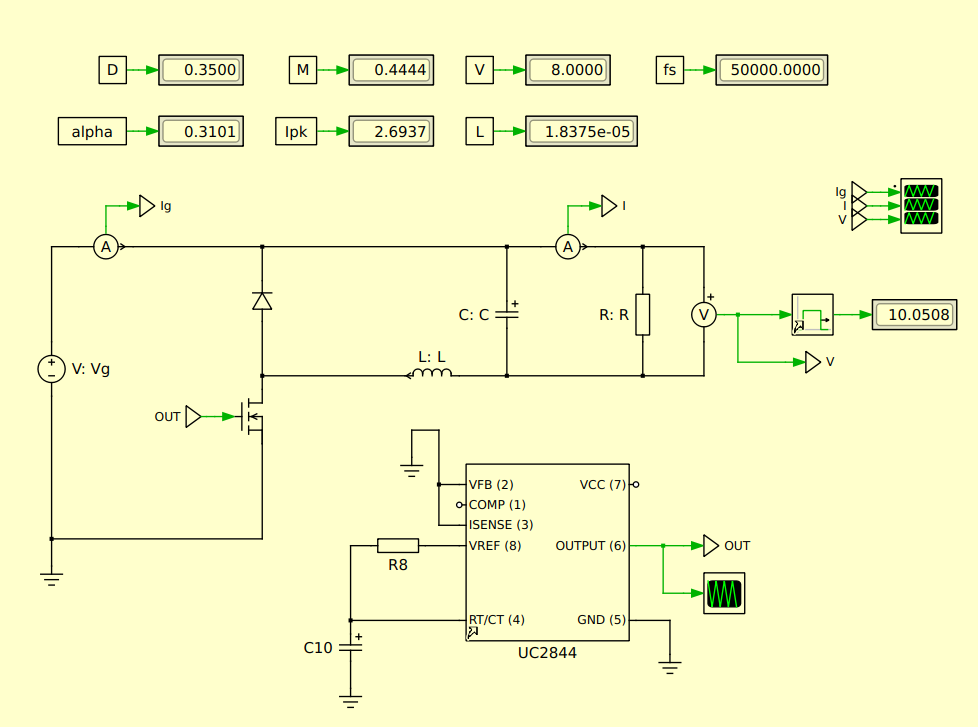


### Task 2

In [85]:
import xmlrpc.client as xml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
model = "lab2_buck_digital_twin"
file_type = ".plecs"
local_host = "http://localhost:1080/RPC2"
plecs = xml.Server(local_host).plecs


In [145]:
object = model + "/Q6/Vcomp"
plecs.get(object)

length = 9
voltages = np.linspace(1.5, 2.3, length)
i_pk = np.zeros(length)

for i in range(length):
    plecs.set(object, 'V', str(round(voltages[i], 1)))
    i_pk[i] = max(plecs.simulate(model)["Values"][3])

print("I_pk:", i_pk)

I_pk: [1.33333333 2.         2.66666667 3.33333333 4.         4.66666667
 5.33333333 6.         6.66666667]


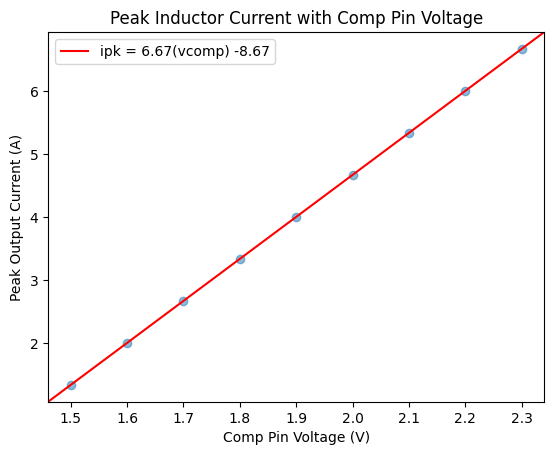

In [148]:
# generate random vectors
plt.scatter(voltages, i_pk, alpha=0.5)

# compute slope m and intercept b
m, b = np.polyfit(voltages, i_pk, deg=1)

# plot fitted I_PK = m*voltages + b
plt.axline(xy1=(1.5, 1.5*m+ b), slope=m, color='r', label=f'ipk = {m:.2f}(vcomp) {b:+.2f}')
plt.title("Peak Inductor Current with Comp Pin Voltage")
plt.xlabel("Comp Pin Voltage (V)")
plt.ylabel("Peak Output Current (A)")
plt.legend()
plt.show()

Q7: Establish an expression for the peak of inductor current (Ipk) as a function of the voltage applied to the COMP pin (Vcomp). How does expression related to the components shown in Fig 12 of the UC2844 datasheet?

$I_{pk} = 6.67 \frac{1}{\Omega} (V_{comp}) - 8.67 \text{A}$

The slope comes from the voltage drop from the internal resistors divided by the shunt resistance, to account for the voltage of isense. The offset comes from the two diode drop of $V_f = 0.65 \, V$ each, again divided by the shunt resistance. 

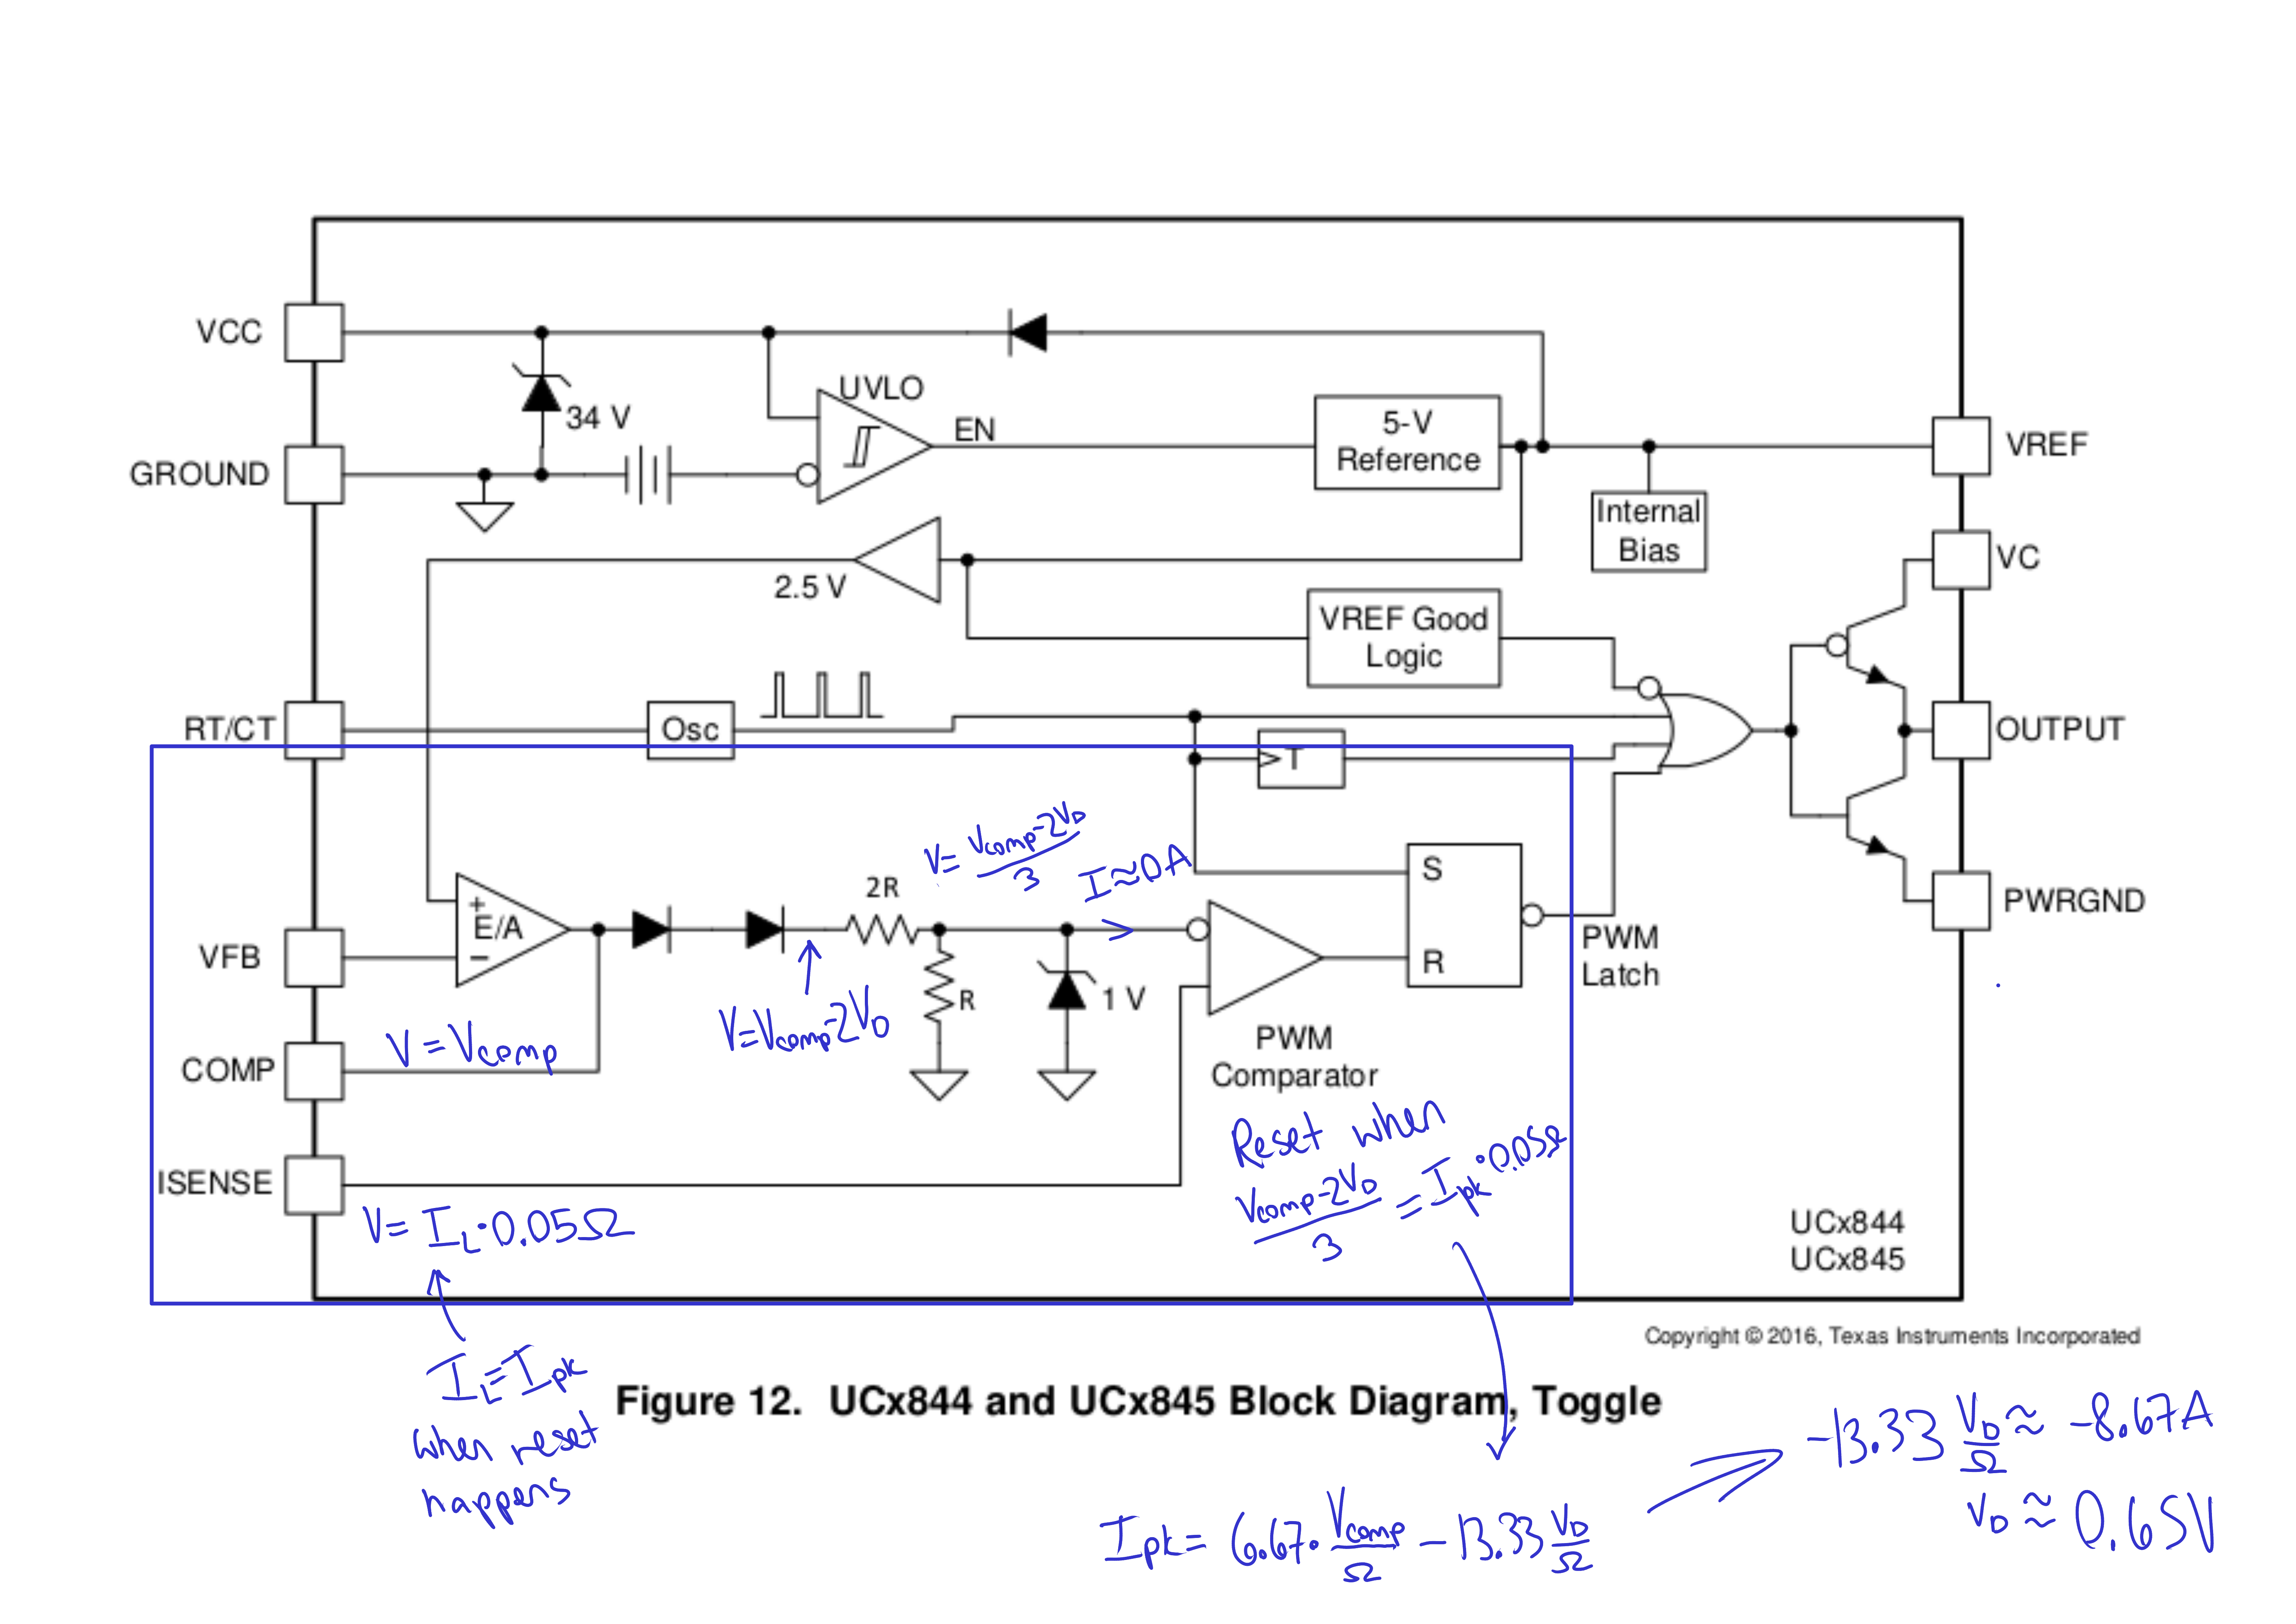

Q8: Implement this equation in the PLECS model initialization script and configure the initialization script to achieve the peak current value calculated in the lab prep that realizes an output of V=8V.

Q9: Plot and comment thoroughly on the following waveforms:

A. Source current Ig

E. Output current

F. Output voltage

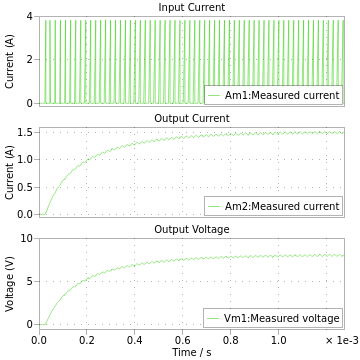 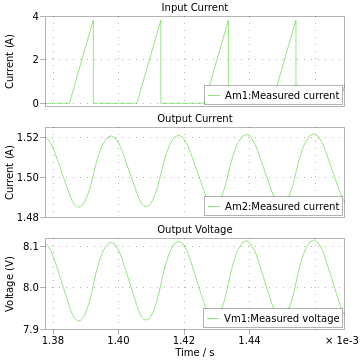

Input current has a sawtooth waveform that stays at 0A for about 65% of its cycle, reaching a peak of 3.81 A and low of 0 A. Prior to reaching steady-state, the waves have a different shape, jumping straight up to a positive current at the start of the sawtooth. It takes about 0.17 ms this wave to reach a steady-state.

Output current reaches a steady-state around 1.2 ms. It averages 1.51 A, with a small ripple that has limits of 1.49 A and 1.52 A.

Output voltage reaches a steady-state around 1.2 ms. It averages 8.04 V, with a small ripple that has limits of 7.94 V and 8.13 V.

B. Shunt voltage Vsh

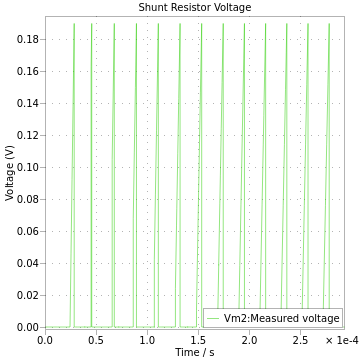 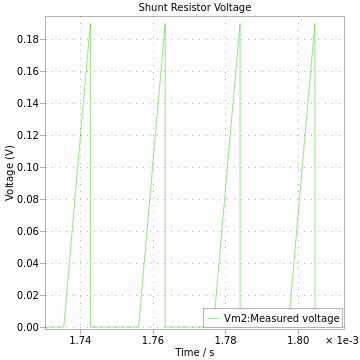 

Shunt voltages reaches a steady-state around 0.17 ms. It follows the same sawtooth shape and period as the input current, which makes sense as the resistor has current flowing (and thus voltage) when the gate is open like the input current. It has a peak of 0.19 V and low of 0 V.

C. FET drain voltage Vd (connection point between diode and FET to GND)

D. Inductor current

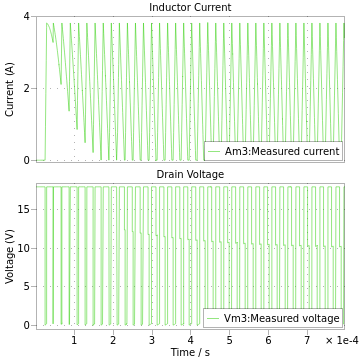 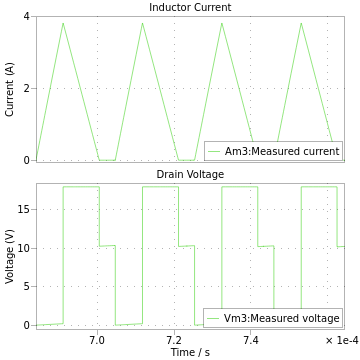

It takes about 0.33 ms for drain voltage to reach its steady-state. When the gate is open, the drain voltage is at approximately 0 V, though it slowly rises slightly. I am unsure what causes this rise, but it seems to mirror the current over the inductor rising. When the gate is closed, it has two stages: one at Vg and one at 10 V. The stage at Vg corresponds to the decreasing inductor current while the stage at 10 V occurs with the inductor current is 0 A.

It takes about 0.33 ms for inductor current to reach its steady-state. Initially, it does not fully reach 0 V. It has a triangle waveform with an extended period at 0V that takes slightly longer to fall than to rise. At it's peak, it reaches 3.8 A, which is our expected peak current. The waveform could potentially be explained as the inductor taking a different amount of time to charge and discharge, though I'm not sure why that would be.

Q10: Copy your PLECS schematic and initialization script into your lab notebook.

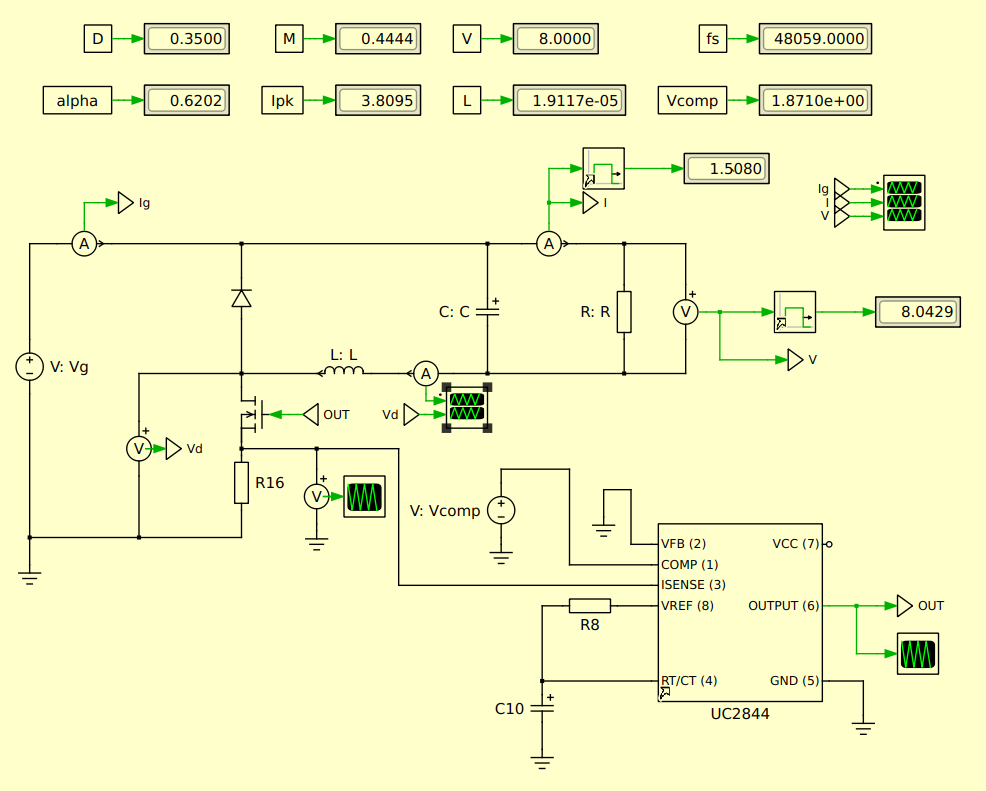

```
R8 = 7870;
C10 = 2.2e-9;

fosc = 1.72 / (R8 * C10);
fs = 48059;
Ts = 1/fs;

C = 60e-6;

Vg = 18;
V = 8;
M = V/Vg;

D = 0.35;
P = 12;

R = V^2/P;
L = D^2 * (1-M)/(M^2) * R / (2*fs);
L_crit = (1-M) * R * (Ts/2);
alpha = L/L_crit;
Ipk = 2/sqrt(alpha) * V / R;

R16 = 0.05;
Vcomp = (Ipk + 8.67)/6.67;
```

### Task 3

Q11: I selected Mystery Inductor #3 because Sush and I are Team 3.

Q12 & Q13:

L is 9.03 $\mu H$

We can find the inductance using Vcomp: 

$V_{comp} = \frac{I_{pk} + 8.67 \, A}{6.67} \, \Omega$

$V_{comp} = \frac{2 \sqrt{\frac{(1-M)R\frac{T_s}{2}}{L}} \frac{V}{R} + 8.67 \, A}{6.67} \, \Omega$

$L = 9.03 \,\mu H$

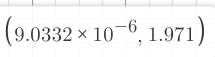

or we can find it using the duty cycle.

$L = D^2 \frac{1-M}{M^2} \frac{R}{2*fs}$

$D = \frac{3.8 \, \mu s}{20.6 \, \mu s}$

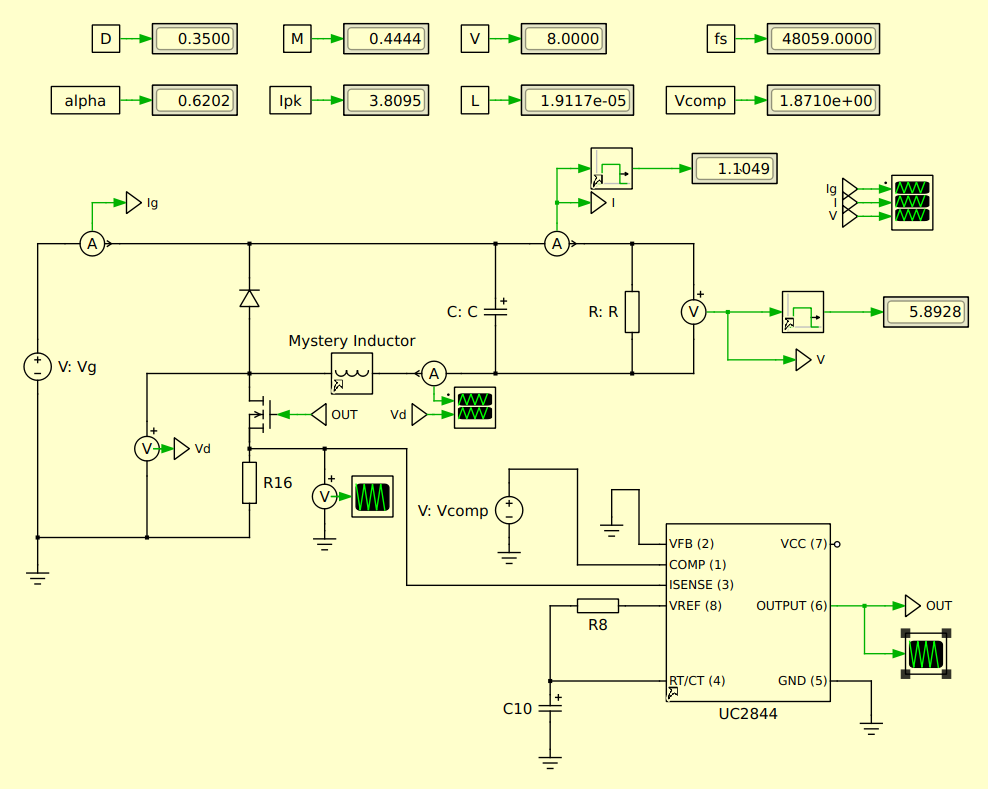